In [14]:
import glob, sys, os
sys.path.append('..')
import output as out
import plot_helper as plt_hp
import pandas as pd
import numpy as np
import torch
from itertools import product
from functools import partial
from effects_of_finetuning import SERVER_PROJECT_PATH
from pytorch_lightning.trainer.trainer import Trainer

sys.path.append('../deep-learning-base')
sys.path.append('../deep-learning-base/datasets')
sys.path.append('../deep-learning-base/training')
import dataset_metadata as dsmd
from data_modules import DATA_MODULES
import architectures as arch
from architectures.callbacks import LightningWrapper
from training import LitProgressBar

In [8]:
model_names = ['vit_base_patch32_224']
# model_names = ['resnet50']

base_datasets = ['imagenet','imagenet21k']
# base_datasets = ['imagenet','imagenet21k-miil','clip']

# finetune_datasets = ['imagenet', 'cifar10', 'cifar100', 'oxford-iiit-pets']
finetune_datasets = ['cifar10', 'cifar100']

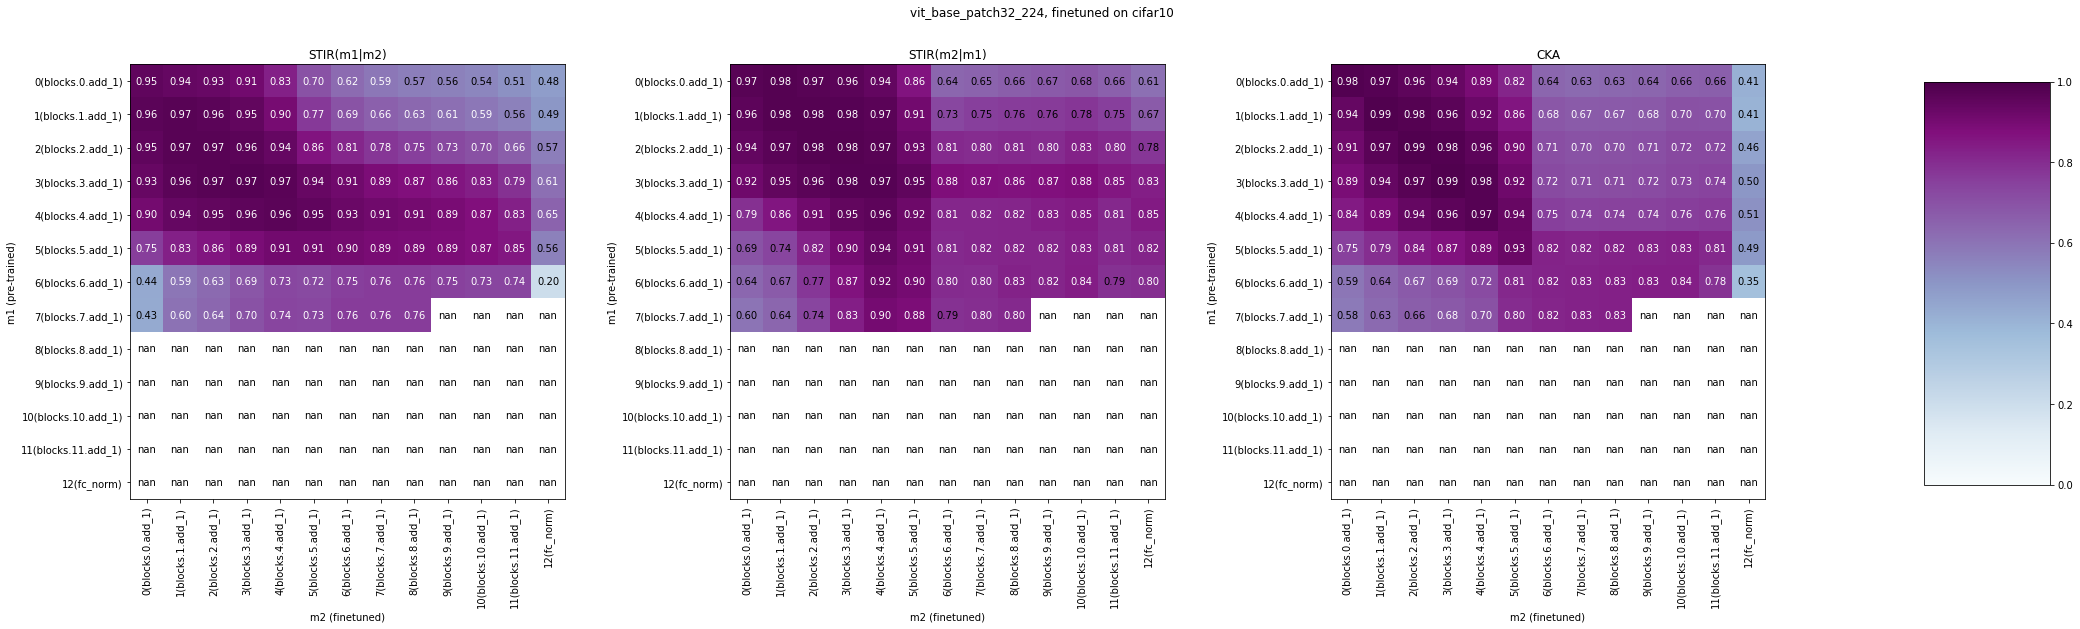

../plot_helper.py:573: RuntimeWarning: All-NaN slice encountered
  thresh = (np.nanmin(maps[i-1]) + np.nanmax(maps[i-1])) / 2.


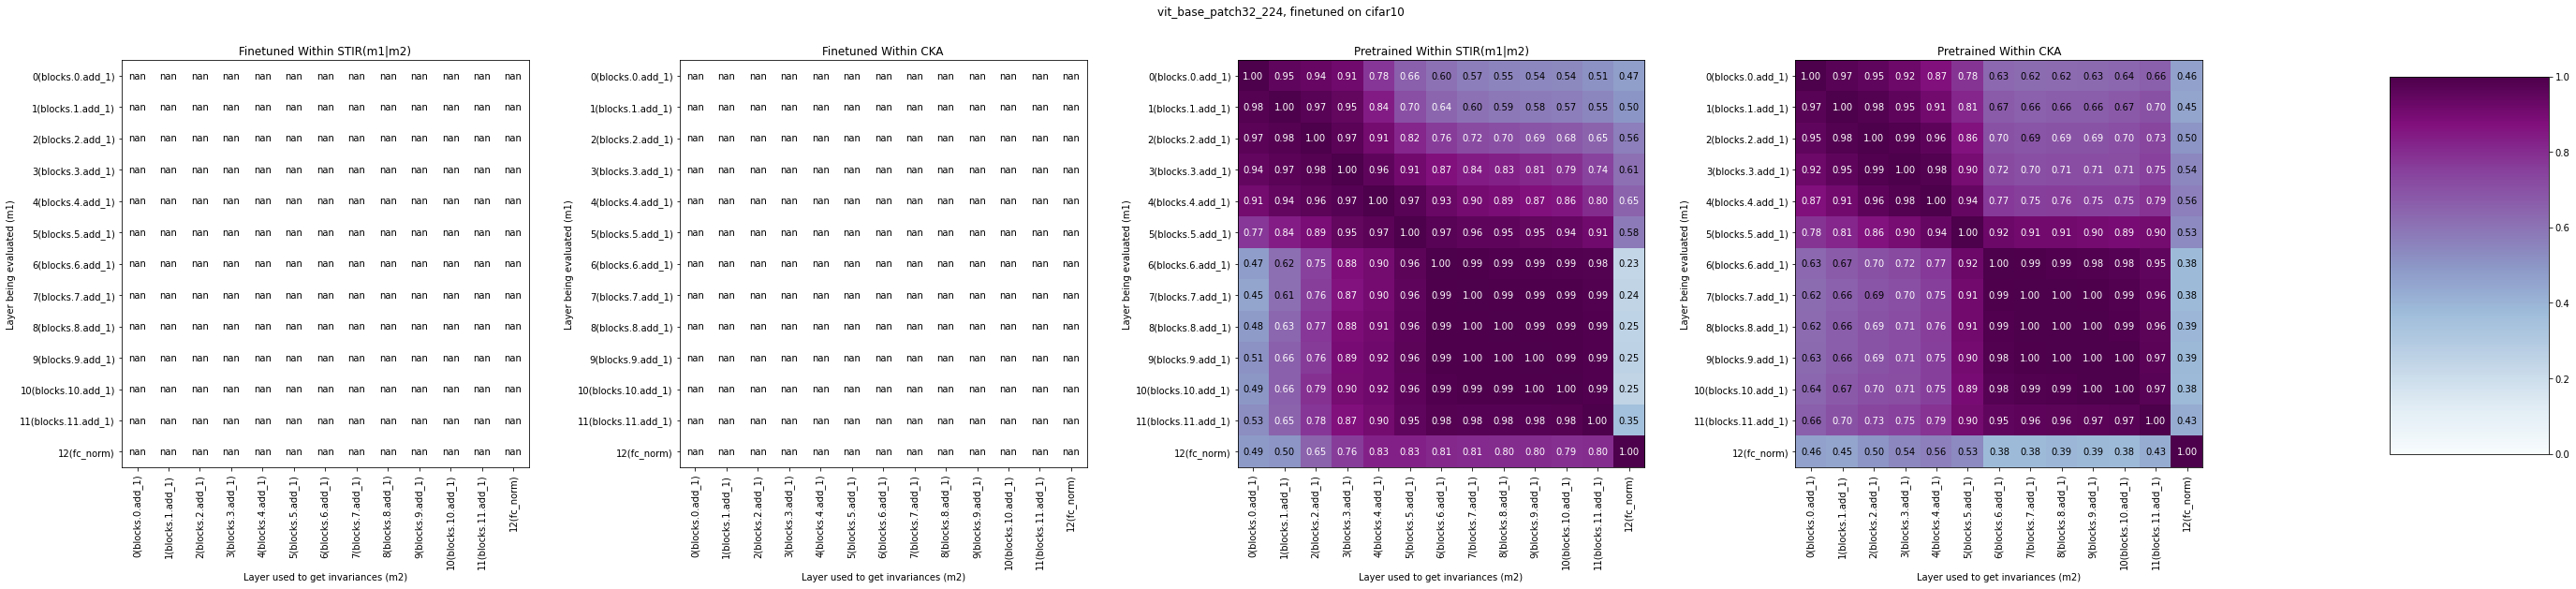

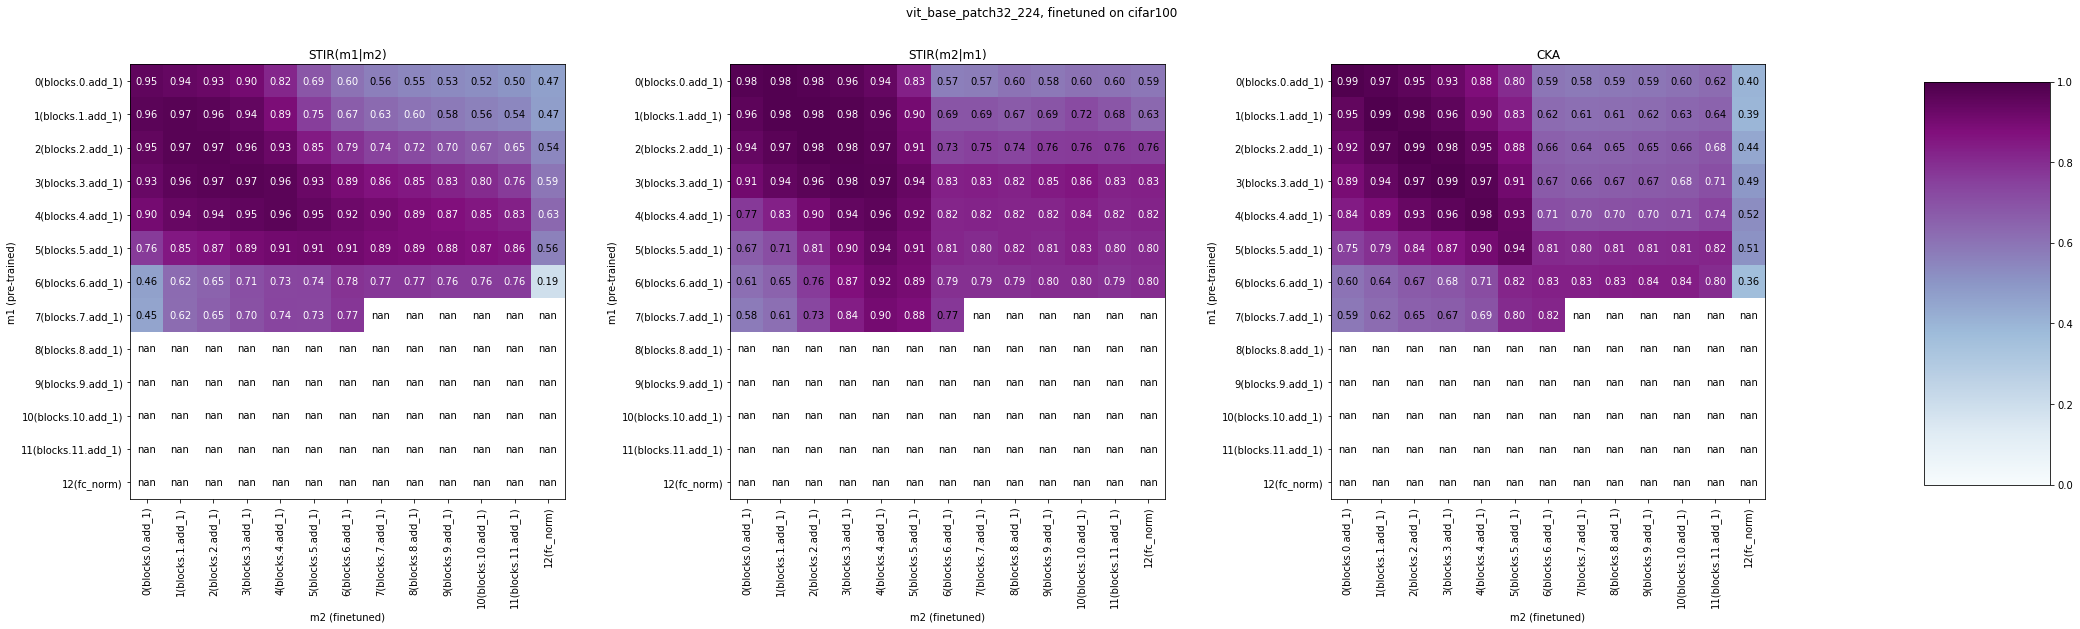

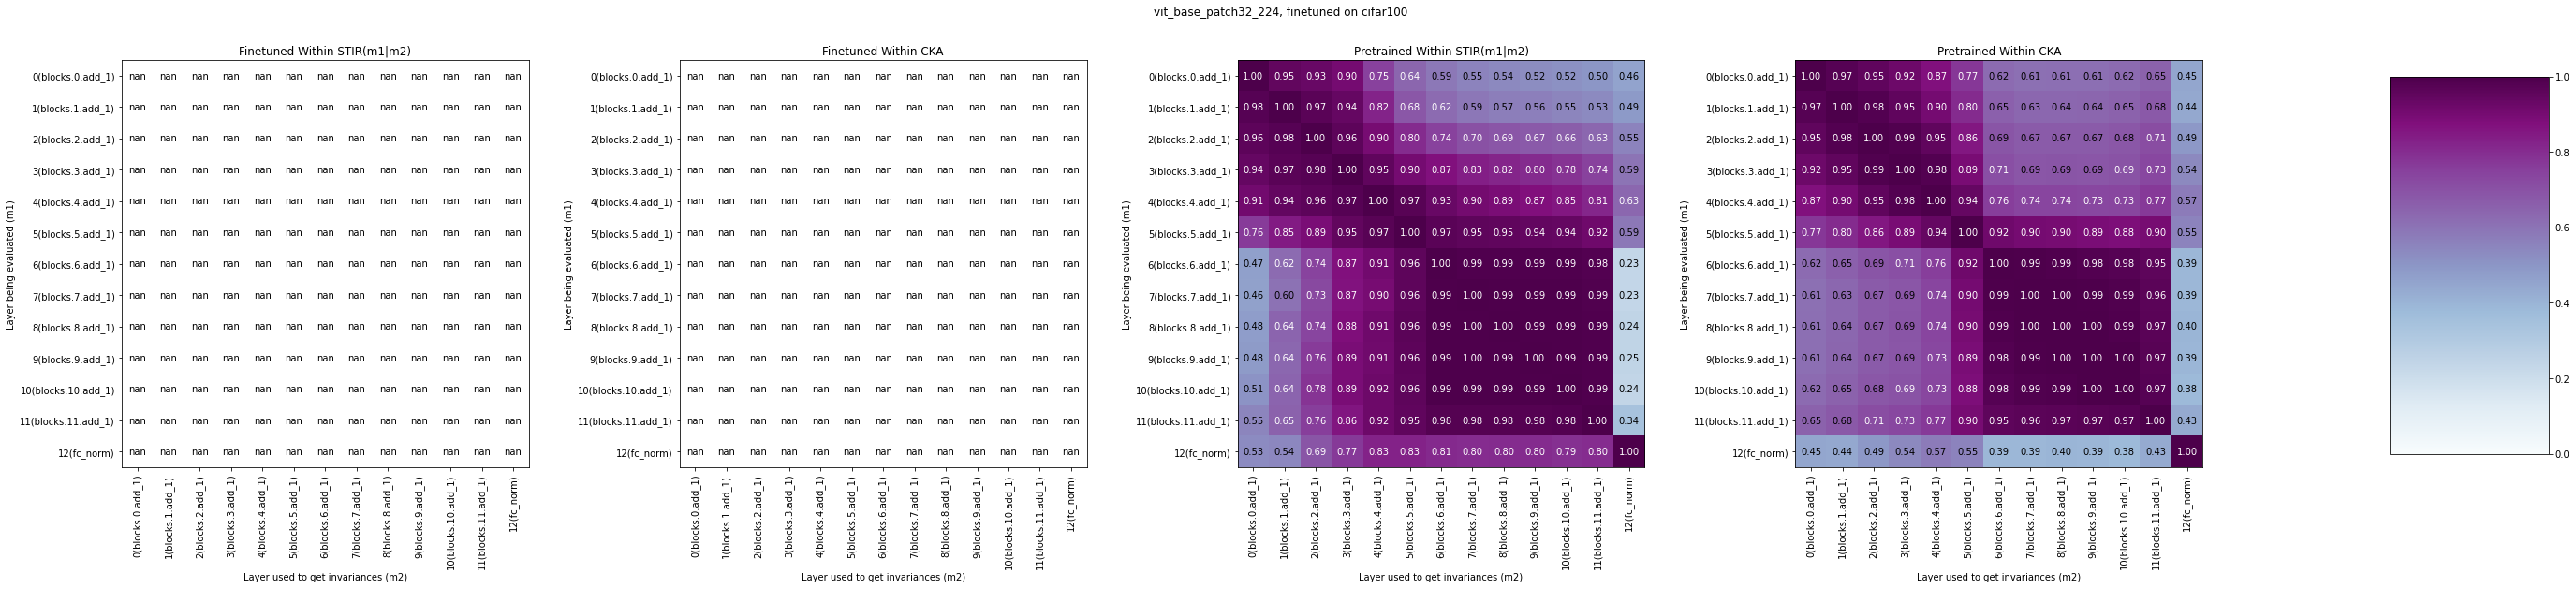

Uploading results in ['results/imagenet/compression_analysis'] to contact.mpi-sws.org...
Uploading 4 files to server
copying results/imagenet/compression_analysis/within_model_layer_analysis_vit_base_patch32_224_eval_cifar100_ftds_cifar100.png to /home/vnanda/public_html/results/effects_of_finetuning/imagenet/compression_analysis/within_model_layer_analysis_vit_base_patch32_224_eval_cifar100_ftds_cifar100.png
copying results/imagenet/compression_analysis/within_model_layer_analysis_vit_base_patch32_224_eval_cifar10_ftds_cifar10.png to /home/vnanda/public_html/results/effects_of_finetuning/imagenet/compression_analysis/within_model_layer_analysis_vit_base_patch32_224_eval_cifar10_ftds_cifar10.png
copying results/imagenet/compression_analysis/cross_layer_analysis_vit_base_patch32_224_eval_cifar100_ftds_cifar100.png to /home/vnanda/public_html/results/effects_of_finetuning/imagenet/compression_analysis/cross_layer_analysis_vit_base_patch32_224_eval_cifar100_ftds_cifar100.png
copying resul

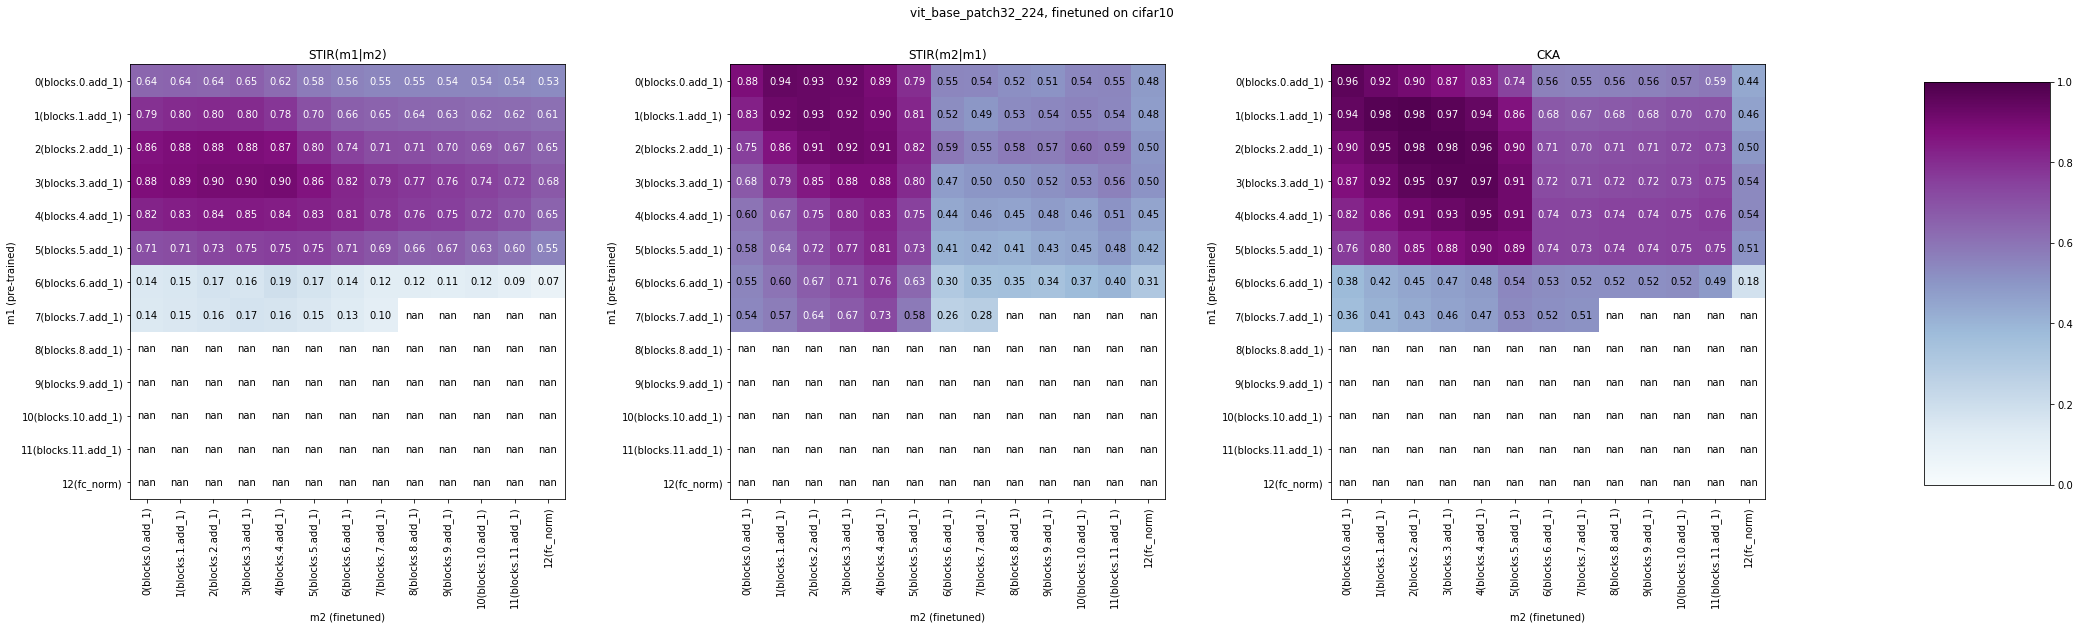

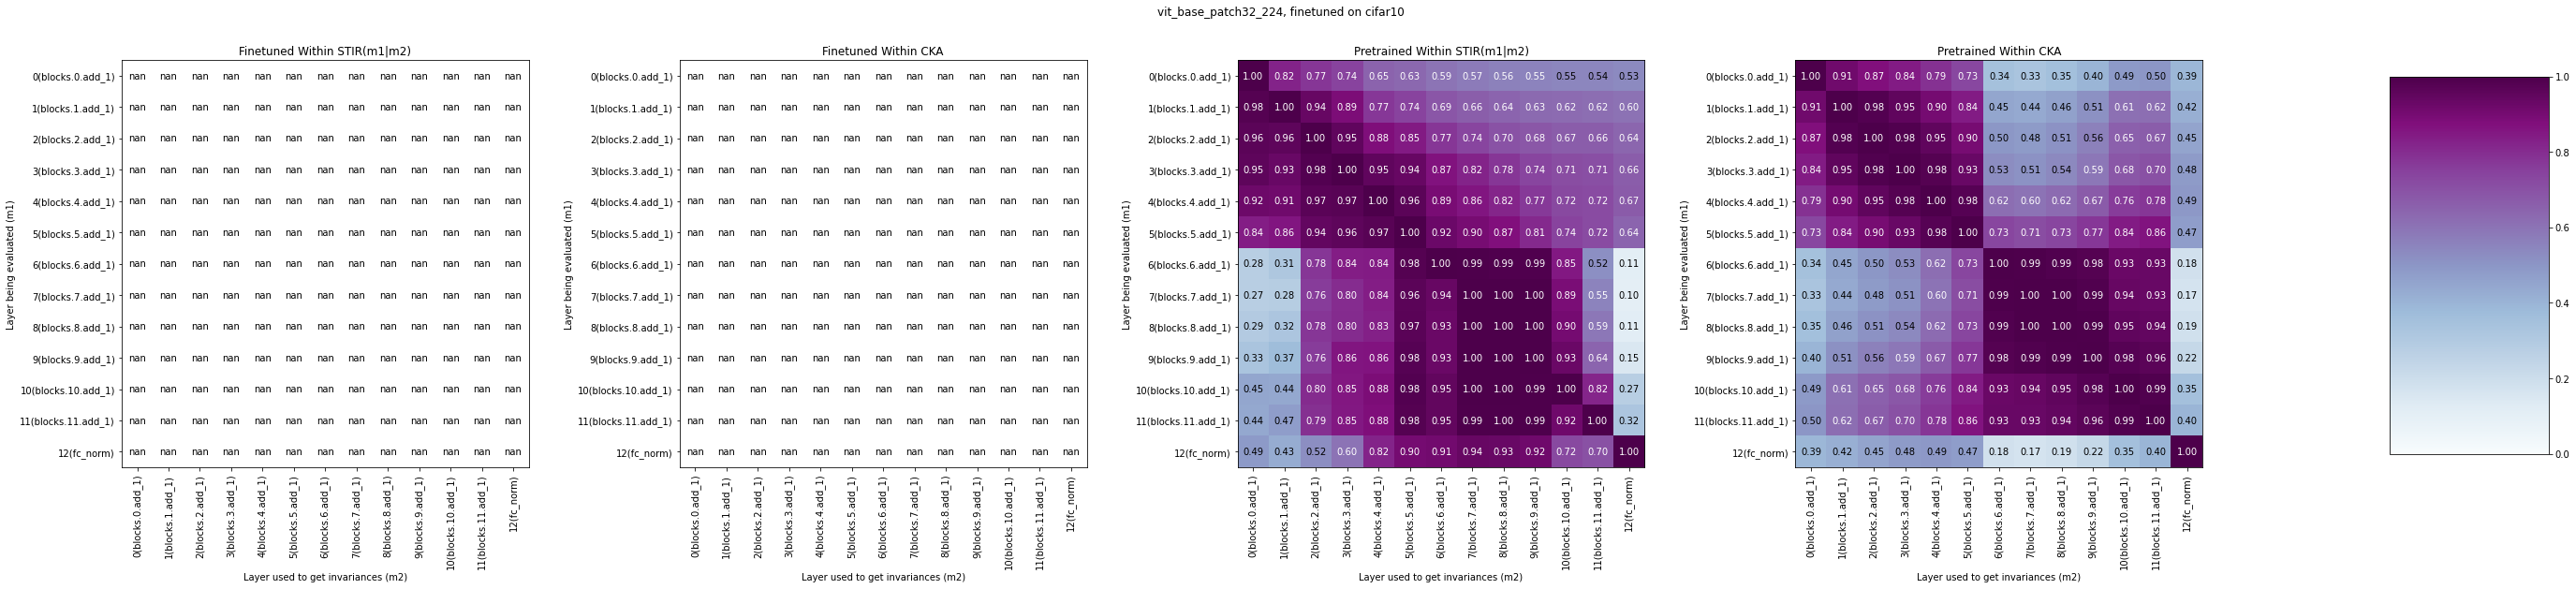

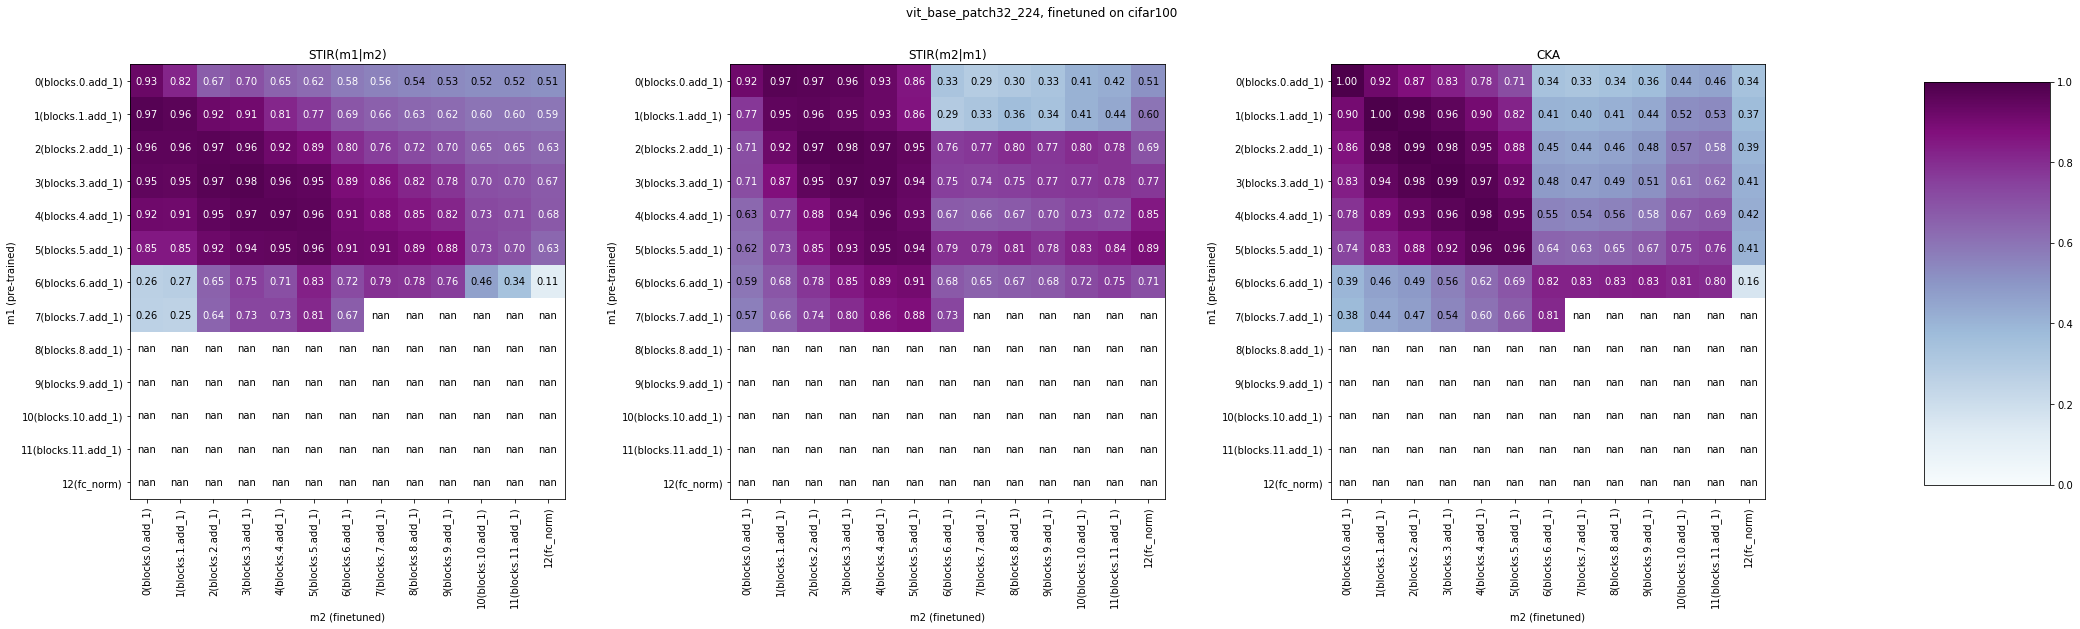

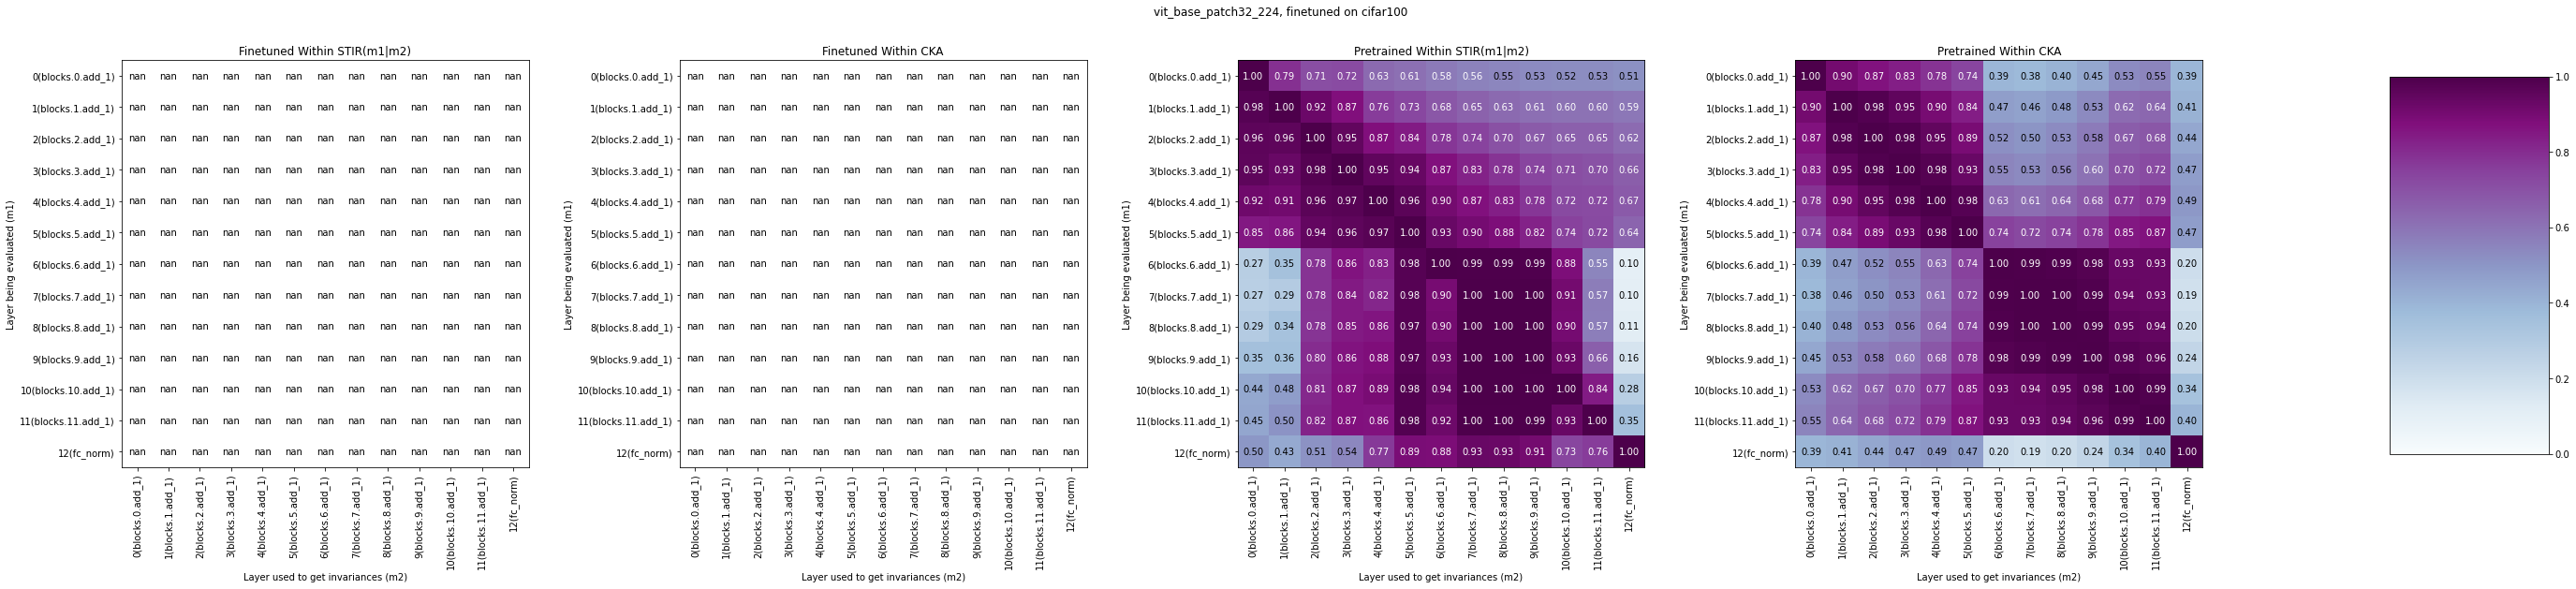

Uploading results in ['results/imagenet21k/compression_analysis'] to contact.mpi-sws.org...
Uploading 27 files to server
copying results/imagenet21k/compression_analysis/within_model_layer_analysis_vit_base_patch32_224_eval_cifar100_ftds_cifar100.png to /home/vnanda/public_html/results/effects_of_finetuning/imagenet21k/compression_analysis/within_model_layer_analysis_vit_base_patch32_224_eval_cifar100_ftds_cifar100.png
copying results/imagenet21k/compression_analysis/cross_layer_analysis_vit_base_patch16_384_eval_oxford-iiit-pets_ftds_oxford-iiit-pets.png to /home/vnanda/public_html/results/effects_of_finetuning/imagenet21k/compression_analysis/cross_layer_analysis_vit_base_patch16_384_eval_oxford-iiit-pets_ftds_oxford-iiit-pets.png
copying results/imagenet21k/compression_analysis/cross_layer_analysis_resnetv2_50x1_bitm_eval_cifar100_ftds_cifar100.png to /home/vnanda/public_html/results/effects_of_finetuning/imagenet21k/compression_analysis/cross_layer_analysis_resnetv2_50x1_bitm_eval_

In [3]:
for base_dataset in base_datasets:
    plt_str = '<<TableOfContents()>>\n\n= Cross Layer Comparison =\n\n'
    for model_name in model_names:
        plt_str += f'== {model_name} ==\n\n'
        for ft_ds in finetune_datasets:
            results_file = f'./results/{model_name}_eval_{ft_ds}-base_'\
                           f'{base_dataset}-finetune_{ft_ds}.txt'
            within_model_ft = f'./results/{model_name}_eval_{ft_ds}-base_'\
                              f'{base_dataset}-{ft_ds}-within-model-finetuned.txt'
            within_model_base = f'./results/{model_name}_eval_{ft_ds}-base_'\
                                f'{base_dataset}-{ft_ds}-within-model-base.txt'
            if os.path.exists(results_file):
                plt_str += f'=== Pre-trained on {base_dataset}, finetuned on {ft_ds}, eval on {ft_ds} ===\n\n'
                df = pd.read_csv(results_file, header=None, sep=',',
                                 names=['Base(m1)', 'Finetuned(m2)', 'STIR(m1|m2)', 'STIR(m2|m1)', 'CKA'])
                layers = df['Finetuned(m2)'].unique()
                df.set_index(['Base(m1)', 'Finetuned(m2)'], inplace=True)
                mat_stir_m1m2 = np.full((len(layers), len(layers)), np.nan)
                mat_stir_m2m1 = np.full((len(layers), len(layers)), np.nan)
                mat_cka = np.full((len(layers), len(layers)), np.nan)
                pretrained_within_stir = np.full((len(layers), len(layers)), np.nan)
                pretrained_within_cka = np.full((len(layers), len(layers)), np.nan)
                finetuned_within_stir = np.full((len(layers), len(layers)), np.nan)
                finetuned_within_cka = np.full((len(layers), len(layers)), np.nan)
                for (i1,l1), (i2,l2) in product(*[enumerate(layers),enumerate(layers)]):
                    if (l1,l2) in df.index:
                        mat_stir_m1m2[i1, i2] = df.loc[l1,l2]['STIR(m1|m2)']
                        mat_stir_m2m1[i1, i2] = df.loc[l1,l2]['STIR(m2|m1)']
                        mat_cka[i1, i2] = df.loc[l1,l2]['CKA']

                plt_str += '{}\n\n'.format(plt_hp.get_wiki_link(
                    plt_hp.plot_heatmaps([mat_stir_m1m2, mat_stir_m2m1, mat_cka], 
                                         layers, layers, plot_title=f'{model_name}, finetuned on {ft_ds}', 
                                     subplot_titles=['STIR(m1|m2)', 'STIR(m2|m1)', 'CKA'], 
                                     subfolder='compression_analysis', 
                                     filename=f'cross_layer_analysis_{model_name}_eval_{ft_ds}_ftds_{ft_ds}', 
                                     file_format='png', vmin=0, vmax=1, show_fig=True, cols=3,
                                     x_title='m2 (finetuned)', y_title='m1 (pre-trained)', 
                                     annotate=True, types=None, 
                                     paper_friendly_plots=False, annotation_fontsize=10, root_dir='.', 
                                     figsize=(35,8), results_subfolder_name=base_dataset),
                    SERVER_PROJECT_PATH, size=2000))

                if os.path.exists(within_model_ft):
                    np.fill_diagonal(finetuned_within_stir, 1.)
                    np.fill_diagonal(finetuned_within_cka, 1.)
                    df_within_ft = pd.read_csv(within_model_ft, header=None, sep=',',
                                               names=['Base(m1)', 'Finetuned(m2)', 
                                                      'STIR(m1|m2)', 'STIR(m2|m1)', 'CKA'],
                                               index_col=[0,1])
                    for (i1,l1), (i2,l2) in product(*[enumerate(layers),enumerate(layers)]):
                        if (l1,l2) in df_within_ft.index:
                            finetuned_within_stir[i1, i2] = df_within_ft.loc[l1,l2]['STIR(m1|m2)']
                            finetuned_within_stir[i2, i1] = df_within_ft.loc[l1,l2]['STIR(m2|m1)']
                            finetuned_within_cka[i1, i2] = df_within_ft.loc[l1,l2]['CKA']
                            finetuned_within_cka[i2, i1] = df_within_ft.loc[l1,l2]['CKA']
                if os.path.exists(within_model_base):
                    np.fill_diagonal(pretrained_within_stir, 1.)
                    np.fill_diagonal(pretrained_within_cka, 1.)
                    df_within_base = pd.read_csv(within_model_base, header=None, sep=',',
                                                 names=['Base(m1)', 'Finetuned(m2)', 
                                                        'STIR(m1|m2)', 'STIR(m2|m1)', 'CKA'],
                                                 index_col=[0,1])
                    for (i1,l1), (i2,l2) in product(*[enumerate(layers),enumerate(layers)]):
                        if (l1,l2) in df_within_base.index:
                            pretrained_within_stir[i1, i2] = df_within_base.loc[l1,l2]['STIR(m1|m2)']
                            pretrained_within_stir[i2, i1] = df_within_base.loc[l1,l2]['STIR(m2|m1)']
                            pretrained_within_cka[i1, i2] = df_within_base.loc[l1,l2]['CKA']
                            pretrained_within_cka[i2, i1] = df_within_base.loc[l1,l2]['CKA']

                plt_str += '{}\n\n'.format(plt_hp.get_wiki_link(
                    plt_hp.plot_heatmaps([finetuned_within_stir, finetuned_within_cka, 
                                          pretrained_within_stir, pretrained_within_cka], 
                                         layers, layers, plot_title=f'{model_name}, finetuned on {ft_ds}', 
                                 subplot_titles=['Finetuned Within STIR(m1|m2)', 
                                                 'Finetuned Within CKA', 
                                                 'Pretrained Within STIR(m1|m2)',
                                                 'Pretrained Within CKA'], 
                                 subfolder='compression_analysis', 
                                 filename=f'within_model_layer_analysis_{model_name}_eval_{ft_ds}_ftds_{ft_ds}', 
                                 file_format='png', vmin=0, vmax=1, show_fig=True, cols=4,
                                 x_title='Layer used to get invariances (m2)', 
                                 y_title='Layer being evaluated (m1)', 
                                 annotate=True, types=None, 
                                 paper_friendly_plots=False, annotation_fontsize=10, root_dir='.', 
                                 figsize=(47,8), results_subfolder_name=base_dataset),
                    SERVER_PROJECT_PATH, size=2000))
    
    with open(f'./results/{base_dataset}/compression_analysis/wiki_results.txt', 'w') as fp:
        fp.write(plt_str)
    out.upload_results(['{}/{}/{}'.format(plt_hp.RESULTS_FOLDER_NAME, base_dataset, 'compression_analysis')], 
        'results', SERVER_PROJECT_PATH, '.png')

### Comparing Linear vs Finetuned Accs

In [15]:
DATA_PATH = '/NS/twitter_archive/work/vnanda/data'
ALT_DATA_PATH = '/NS/robustness_1/work/vnanda/data'
BATCH_SIZE = 500

In [16]:
model_names = ['resnet50','vit_base_patch32_224']
# model_names = ['resnet50']

base_datasets = {
    'resnet50':['imagenet','imagenet21k-miil','clip'],
    'vit_base_patch32_224':['imagenet','imagenet21k','clip']}
# base_datasets = ['imagenet','imagenet21k-miil','clip']

# finetune_datasets = ['imagenet', 'cifar10', 'cifar100', 'oxford-iiit-pets']
finetune_datasets = ['cifar10', 'cifar100']

In [17]:
def accuracy(gt, pred):
    pred = torch.argmax(pred, 1)
    return torch.sum(gt == pred) / len(gt)

In [20]:
plt_str = '== Accuracy Comparison Linear vs Finetuned ==\n\n'
for ft_ds in finetune_datasets:
    x_labels, accs_full, accs_linear = [], [], []
    for model_name in model_names:
        for base_dataset in base_datasets[model_name]:
            dm = DATA_MODULES[ft_ds](
                data_dir=DATA_PATH if 'imagenet' in ft_ds else ALT_DATA_PATH,
                val_frac=0.,
                transform_train=dsmd.TEST_TRANSFORMS_DEFAULT(224),
                transform_test=dsmd.TEST_TRANSFORMS_DEFAULT(224),
                batch_size=BATCH_SIZE)
            dm.init_remaining_attrs(ft_ds)
            
            base_path = f'checkpoints/{model_name}-base-{base_dataset}-ft-{ft_ds}'
            full_checkpoint_path = glob.glob(f'{base_path}/ftmode-full-lr-0.001-bs-256*-warmup-'
                f'{dsmd.DATASET_PARAMS[ft_ds]["warmup_steps"]}/*-topk=1.ckpt')[0]
            linear_checkpoint_path = glob.glob(f'{base_path}/ftmode-linear-lr-0.001-bs-256*/*-topk=1.ckpt')[0]
            
            m_full = arch.create_model(model_name, base_dataset, pretrained=True,
                                       checkpoint_path=full_checkpoint_path, 
                                       num_classes=dsmd.DATASET_PARAMS[ft_ds]['num_classes'],
                                       loading_function_kwargs={'strict': True},
                                       callback=partial(LightningWrapper, 
                                                        mean=dsmd.DATASET_PARAMS[base_dataset]['mean'],
                                                        std=dsmd.DATASET_PARAMS[base_dataset]['std'],
                                                        training_params_dataset=ft_ds))
            m_linear = arch.create_model(model_name, base_dataset, pretrained=True,
                                         checkpoint_path=linear_checkpoint_path, 
                                         num_classes=dsmd.DATASET_PARAMS[ft_ds]['num_classes'],
                                         loading_function_kwargs={'strict': False},
                                         callback=partial(LightningWrapper, 
                                                          mean=dsmd.DATASET_PARAMS[base_dataset]['mean'],
                                                          std=dsmd.DATASET_PARAMS[base_dataset]['std'],
                                                          training_params_dataset=ft_ds))
            
            trainer = Trainer(accelerator='gpu', devices=1,
                              num_nodes=1, log_every_n_steps=1,
                              auto_select_gpus=True, deterministic=True,
                              check_val_every_n_epoch=1, num_sanity_val_steps=0,
                              callbacks=[LitProgressBar(['loss', 'running_test_acc'])])
            out_full = trainer.predict(m_full, dataloaders=[dm.test_dataloader()])
            acc_full = accuracy(out_full[1], out_full[0]).item()
            out_linear = trainer.predict(m_linear, dataloaders=[dm.test_dataloader()])
            acc_linear = accuracy(out_linear[1], out_linear[0]).item()
            
            x_labels.append(f'{model_name}-{base_dataset}')
            accs_full.append(acc_full)
            accs_linear.append(acc_linear)
    
    plt_str += '=== Finetuned on: {} ===\n\n{}\n\n'.format(ft_ds, plt_hp.get_wiki_link(
        plt_hp.line_plot([accs_full, accs_linear], 'Model,Dataset', 'Accuracy', 
                         f'Finetuned on: {ft_ds}', subfolder='compression_analysis', 
                         filename=f'finetune_performance_linear_vs_full_{ft_ds}', 
                         extension='png', x_vals=x_labels, legend_vals=['Full', 'Linear Probe'],
                         colors=plt_hp.COLORS[:1] + plt_hp.COLORS[:1], linestyles=['-', '.'],
                         y_lims=None, root_dir='.', paper_friendly_plots=False, 
                         plot_inside=False, legend_location='best', savefig=True, figsize=(6,4), 
                         marker=True, results_subfolder_name='linear_vs_full', 
                         grid_spacing=None),
                    SERVER_PROJECT_PATH, size=1000))
    
    with open(f'./results/linear_vs_full/compression_analysis/wiki_results.txt', 'w') as fp:
        fp.write(plt_str)
    out.upload_results(['{}/{}/{}'.format(
        plt_hp.RESULTS_FOLDER_NAME, 'linear_vs_full', 'compression_analysis')], 
        'results', SERVER_PROJECT_PATH, '.png')

Global seed set to 0
Global seed set to 0
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Predicting: 0it [00:00, ?it/s]

torch.Size([10000, 10]) torch.Size([10000])


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)